#  Singapore  Resale Flat Prices Predicting

 # step1: Import and Reading Data
 

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score
import warnings
import pickle
warnings.filterwarnings('ignore')
plt.style.use('seaborn-pastel')
pd.set_option('display.max_rows', 200)

In [310]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline, make_pipeline

In [2]:
# READ CSV FILE

data=pd.read_excel(r"C:\Users\vijiv\OneDrive\Desktop\project GUVi\singapore flat project\singapore resalee.xlsx")
data.head()

,Source.Name,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,10 TO 12,31,IMPROVED,1977,9000.0
1,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,04 TO 06,31,IMPROVED,1977,6000.0
2,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,10 TO 12,31,IMPROVED,1977,8000.0
3,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,07 TO 09,31,IMPROVED,1977,6000.0
4,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,3 ROOM,216.0,ANG MO KIO AVE 1,04 TO 06,73,NEW GENERATION,1976,47200.0


# step2:Understanding the data 

In [3]:
data.shape # total number of rows and columns

(913469, 11)

In [4]:
data.describe()

,block,floor_area_sqm,lease_commence_date,resale_price
count,794553.000000,913469.000000,913469.000000,7.090500e+05
mean,337.661583,95.698127,1988.126834,2.695165e+05
std,254.022522,25.852578,10.508571,1.345352e+05
min,1.000000,28.000000,1966.000000,5.000000e+03
25%,120.000000,73.000000,1981.000000,1.680000e+05
50%,280.000000,93.000000,1986.000000,2.500000e+05
75%,525.000000,113.000000,1996.000000,3.530000e+05
max,980.000000,307.000000,2022.000000,1.088888e+06


In [5]:
data['town'].value_counts()  # to count the each number of town

TAMPINES           79020
YISHUN             69126
BEDOK              65980
JURONG WEST        65693
WOODLANDS          64536
ANG MO KIO         51571
HOUGANG            49940
BUKIT BATOK        43573
CHOA CHU KANG      37702
BUKIT MERAH        33848
PASIR RIS          32893
SENGKANG           31482
TOA PAYOH          31161
QUEENSTOWN         28445
GEYLANG            27893
CLEMENTI           27767
BUKIT PANJANG      27283
KALLANG/WHAMPOA    26777
JURONG EAST        24486
SERANGOON          22602
BISHAN             21090
PUNGGOL            19675
SEMBAWANG          13346
MARINE PARADE       7972
CENTRAL AREA        7058
BUKIT TIMAH         2486
LIM CHU KANG          64
Name: town, dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913469 entries, 0 to 913468
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Source.Name          913469 non-null  object        
 1   month                913469 non-null  datetime64[ns]
 2   town                 913469 non-null  object        
 3   flat_type            913469 non-null  object        
 4   block                794553 non-null  float64       
 5   street_name          913469 non-null  object        
 6   storey_range         913469 non-null  object        
 7   floor_area_sqm       913469 non-null  int64         
 8   flat_model           913469 non-null  object        
 9   lease_commence_date  913469 non-null  int64         
 10  resale_price         709050 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 76.7+ MB


# step3: Data preparation

In [7]:
data.isna().sum()

Source.Name                 0
month                       0
town                        0
flat_type                   0
block                  118916
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price           204419
dtype: int64

In [8]:
data.duplicated().sum() # find the duplicate data

12586

In [9]:
data = data.drop_duplicates() # remove the duplicate data

In [10]:
data.shape

(900883, 11)

<Axes: >

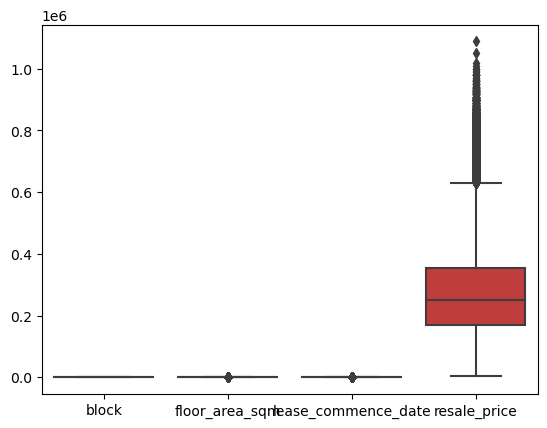

In [11]:
sns.boxplot(data) # to check the ouliers

<Axes: xlabel='resale_price'>

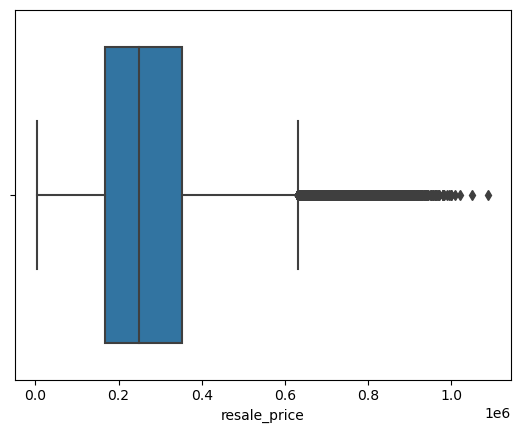

In [91]:
sns.boxplot(x = 'resale_price', data = data)

In [92]:
#To remove outliers we use specific column in a dataframe using the IRQ method
def remove_outliers(data, column_name):

    # Calculate the first and third quartiles
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)

#Calculate the IQR (Interquartile Range)
    IQR = Q3 - Q1

# Define the lower and upper bounds for outlier removal
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

# Remove outliers
    data_no_outliers = data[(data[column_name] >= lower_bound) & (data[column_name] <= upper_bound)]

    return data_no_outliers

data1=remove_outliers(data,'resale_price')

In [93]:
# after removing outlier from resale price column we get
data1.shape

(698438, 11)

<Axes: xlabel='resale_price'>

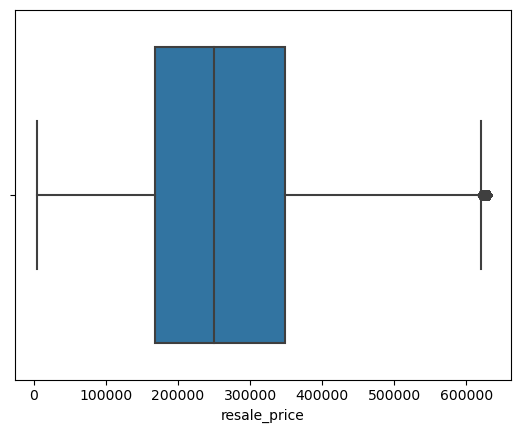

In [15]:
sns.boxplot(x='resale_price',data=data1)

In [166]:
# to check how much percentage is reduced from original data by removing outliers
c = round(((data.shape[0] - data1.shape[0]) / data.shape[0])*100 , 3)
print(f'Removed Outliers which consisted of {c} % of the orignal data')

Removed Outliers which consisted of 22.472 % of the orignal data


<Axes: xlabel='floor_area_sqm'>

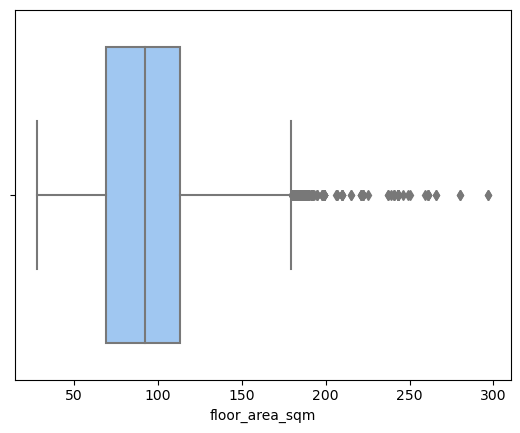

In [167]:
sns.boxplot(x='floor_area_sqm',data=data1)

In [168]:
remove_outliers(data1,'floor_area_sqm')

,Source.Name,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,10 TO 12,31,IMPROVED,1977,9000.0
1,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,04 TO 06,31,IMPROVED,1977,6000.0
2,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,10 TO 12,31,IMPROVED,1977,8000.0
3,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,1 ROOM,309.0,ANG MO KIO AVE 1,07 TO 09,31,IMPROVED,1977,6000.0
4,ResaleFlatPricesBasedonApprovalDate19901999.csv,1990-01-01,ANG MO KIO,3 ROOM,216.0,ANG MO KIO AVE 1,04 TO 06,73,NEW GENERATION,1976,47200.0
...,...,...,...,...,...,...,...,...,...,...,...
913463,ResaleFlatPricesBasedonRegistrationDateFromMar...,2014-12-01,YISHUN,5 ROOM,819.0,YISHUN ST 81,01 TO 03,127,Improved,1987,500000.0
913464,ResaleFlatPricesBasedonRegistrationDateFromMar...,2014-12-01,YISHUN,5 ROOM,816.0,YISHUN ST 81,10 TO 12,122,Improved,1988,580000.0
913465,ResaleFlatPricesBasedonRegistrationDateFromMar...,2014-12-01,YISHUN,EXECUTIVE,325.0,YISHUN CTRL,10 TO 12,146,Maisonette,1988,540000.0
913467,ResaleFlatPricesBasedonRegistrationDateFromMar...,2014-12-01,YISHUN,EXECUTIVE,277.0,YISHUN ST 22,07 TO 09,152,Maisonette,1985,592000.0


# Feature Engineering

In [169]:
data2 = data1
data2 = data1[['flat_type','storey_range','floor_area_sqm', 'flat_model', 'lease_commence_date','resale_price','town']]
data2.head()

,flat_type,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,town
0,1 ROOM,10 TO 12,31,IMPROVED,1977,9000.0,ANG MO KIO
1,1 ROOM,04 TO 06,31,IMPROVED,1977,6000.0,ANG MO KIO
2,1 ROOM,10 TO 12,31,IMPROVED,1977,8000.0,ANG MO KIO
3,1 ROOM,07 TO 09,31,IMPROVED,1977,6000.0,ANG MO KIO
4,3 ROOM,04 TO 06,73,NEW GENERATION,1976,47200.0,ANG MO KIO


In [170]:
data2['age_of_flat'] = 2023 - data2['lease_commence_date']
data2['price_per_square_meter'] = data2['resale_price'] / data2['floor_area_sqm']
data2['town'] = data2.town.astype('category')
data2['flat_model']=data2.flat_model.astype('category')

In [171]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698438 entries, 0 to 913468
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   flat_type               698438 non-null  object  
 1   storey_range            698438 non-null  object  
 2   floor_area_sqm          698438 non-null  int64   
 3   flat_model              698438 non-null  category
 4   lease_commence_date     698438 non-null  int64   
 5   resale_price            698438 non-null  float64 
 6   town                    698438 non-null  category
 7   age_of_flat             698438 non-null  int64   
 8   price_per_square_meter  698438 non-null  float64 
dtypes: category(2), float64(2), int64(3), object(2)
memory usage: 44.0+ MB


In [172]:
#renaming the column for understanding
data2=data2.rename(columns={'flat_type':"number_of_rooms",'storey_range':"storey"})

In [173]:
data2['number_of_rooms'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION', 'MULTI-GENERATION'], dtype=object)

In [174]:
# here there is a seperate name for same type of room so that is change to single category
def mulgen(x):
    if x=='MULTI-GENERATION':
        return 'MULTI GENERATION'
    else:
        return x

data2['number_of_rooms'] =data2['number_of_rooms'].apply(mulgen)

In [103]:
data2['number_of_rooms'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', 'EXECUTIVE',
       'MULTI GENERATION'], dtype=object)

In [175]:
# we are trying to change this number of rooms column to numeric so we are changing to room 6 and 7
data2['number_of_rooms']=data2['number_of_rooms'].str.replace(r'MULTI GENERATION','6 ROOM',regex=True)
data2['number_of_rooms']=data2['number_of_rooms'].str.replace(r'EXECUTIVE','7 ROOM',regex=True)

In [176]:
data2['number_of_rooms'].unique()

array(['1 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', '2 ROOM', '7 ROOM',
       '6 ROOM'], dtype=object)

In [177]:
#Since machine learning can only take numeric inputs, we will have to convert useful categorical columns to numeric form 

data2['number_of_rooms']=data2['number_of_rooms'].apply(lambda x:int(x.split(' ')[0]))

In [178]:
data2

,number_of_rooms,storey,floor_area_sqm,flat_model,lease_commence_date,resale_price,town,age_of_flat,price_per_square_meter
0,1,10 TO 12,31,IMPROVED,1977,9000.0,ANG MO KIO,46,290.322581
1,1,04 TO 06,31,IMPROVED,1977,6000.0,ANG MO KIO,46,193.548387
2,1,10 TO 12,31,IMPROVED,1977,8000.0,ANG MO KIO,46,258.064516
3,1,07 TO 09,31,IMPROVED,1977,6000.0,ANG MO KIO,46,193.548387
4,3,04 TO 06,73,NEW GENERATION,1976,47200.0,ANG MO KIO,47,646.575342
...,...,...,...,...,...,...,...,...,...
913463,5,01 TO 03,127,Improved,1987,500000.0,YISHUN,36,3937.007874
913464,5,10 TO 12,122,Improved,1988,580000.0,YISHUN,35,4754.098361
913465,7,10 TO 12,146,Maisonette,1988,540000.0,YISHUN,35,3698.630137
913467,7,07 TO 09,152,Maisonette,1985,592000.0,YISHUN,38,3894.736842


In [179]:
# let take the last 2 digit value as a data 
data2['storey'] = data2['storey'].str[-2:].astype('int')

In [180]:
data2

,number_of_rooms,storey,floor_area_sqm,flat_model,lease_commence_date,resale_price,town,age_of_flat,price_per_square_meter
0,1,12,31,IMPROVED,1977,9000.0,ANG MO KIO,46,290.322581
1,1,6,31,IMPROVED,1977,6000.0,ANG MO KIO,46,193.548387
2,1,12,31,IMPROVED,1977,8000.0,ANG MO KIO,46,258.064516
3,1,9,31,IMPROVED,1977,6000.0,ANG MO KIO,46,193.548387
4,3,6,73,NEW GENERATION,1976,47200.0,ANG MO KIO,47,646.575342
...,...,...,...,...,...,...,...,...,...
913463,5,3,127,Improved,1987,500000.0,YISHUN,36,3937.007874
913464,5,12,122,Improved,1988,580000.0,YISHUN,35,4754.098361
913465,7,12,146,Maisonette,1988,540000.0,YISHUN,35,3698.630137
913467,7,9,152,Maisonette,1985,592000.0,YISHUN,38,3894.736842


In [181]:
data2['flat_model'].value_counts()

Model A                118691
Improved               111495
New Generation          81109
NEW GENERATION          78646
IMPROVED                73291
MODEL A                 70222
Simplified              25414
SIMPLIFIED              23211
Premium Apartment       22484
Standard                18328
STANDARD                17316
Apartment               16078
MAISONETTE              11696
Maisonette               9972
APARTMENT                9602
Model A2                 7468
MODEL A-MAISONETTE        978
Adjoined flat             770
Model A-Maisonette        611
MULTI GENERATION          245
TERRACE                   241
Terrace                   232
Multi Generation          145
Premium Maisonette         54
Improved-Maisonette        46
IMPROVED-MAISONETTE        44
2-ROOM                     21
2-room                     16
DBSS                       10
PREMIUM APARTMENT           2
Name: flat_model, dtype: int64

In [182]:
# In flat_model column same type are in upper and lower case so it is completly changed to lower case
data2['flat_model']=data2['flat_model'].str.lower()

In [183]:
town_stats=data2.groupby('town')['town'].agg('count').sort_values(ascending=False)
town_stats

town
TAMPINES           64500
YISHUN             55270
BEDOK              54015
JURONG WEST        51566
WOODLANDS          49728
ANG MO KIO         42335
HOUGANG            39351
BUKIT BATOK        35696
CHOA CHU KANG      28177
PASIR RIS          26162
BUKIT MERAH        24525
TOA PAYOH          24070
CLEMENTI           22651
GEYLANG            22369
QUEENSTOWN         21873
JURONG EAST        20068
KALLANG/WHAMPOA    20066
BUKIT PANJANG      19517
SERANGOON          18368
BISHAN             16456
SENGKANG           14658
SEMBAWANG           7879
MARINE PARADE       6430
PUNGGOL             5595
CENTRAL AREA        5229
BUKIT TIMAH         1821
LIM CHU KANG          63
Name: town, dtype: int64

In [184]:
data2

,number_of_rooms,storey,floor_area_sqm,flat_model,lease_commence_date,resale_price,town,age_of_flat,price_per_square_meter
0,1,12,31,improved,1977,9000.0,ANG MO KIO,46,290.322581
1,1,6,31,improved,1977,6000.0,ANG MO KIO,46,193.548387
2,1,12,31,improved,1977,8000.0,ANG MO KIO,46,258.064516
3,1,9,31,improved,1977,6000.0,ANG MO KIO,46,193.548387
4,3,6,73,new generation,1976,47200.0,ANG MO KIO,47,646.575342
...,...,...,...,...,...,...,...,...,...
913463,5,3,127,improved,1987,500000.0,YISHUN,36,3937.007874
913464,5,12,122,improved,1988,580000.0,YISHUN,35,4754.098361
913465,7,12,146,maisonette,1988,540000.0,YISHUN,35,3698.630137
913467,7,9,152,maisonette,1985,592000.0,YISHUN,38,3894.736842


# Exploratory Data Analyst

# univarient

(0.0, 200000.0)

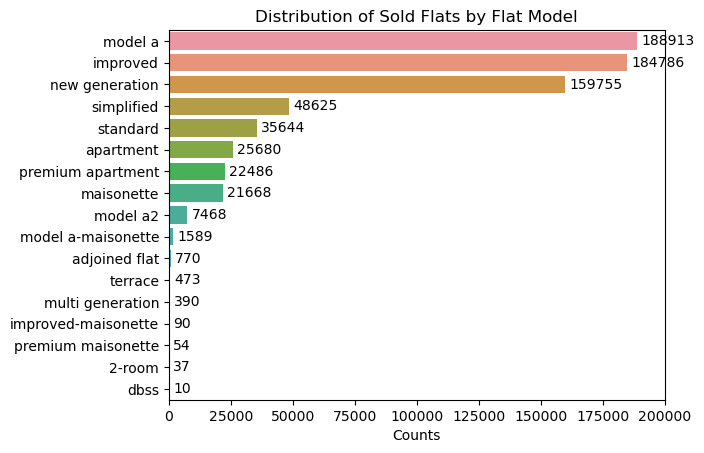

In [185]:
ax=sns.barplot(y=data2['flat_model'].value_counts().index, x=data2['flat_model'].value_counts().values)
plt.title('Distribution of Sold Flats by Flat Model')
plt.xlabel('Counts')
ax.bar_label(ax.containers[0], label_type='edge', padding= 3)
ax.set_xlim(0, 200000)

Text(0.5, 0, 'rooms')

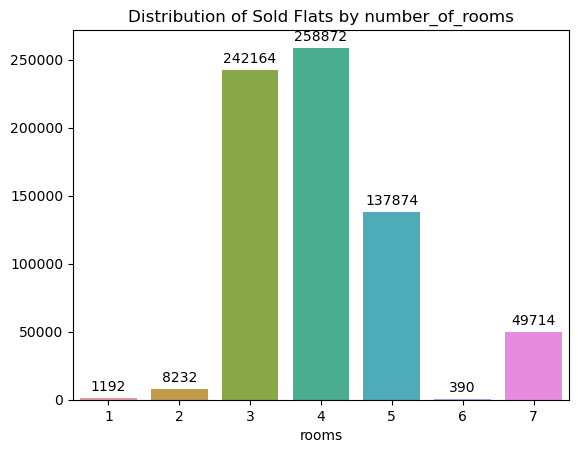

In [186]:
bx=sns.barplot(x=data2['number_of_rooms'].value_counts().index, y=data2['number_of_rooms'].value_counts().values)
plt.title('Distribution of Sold Flats by number_of_rooms')
bx.bar_label(bx.containers[0], label_type='edge', padding= 3)
plt.xlabel('rooms')

Text(0.5, 0, 'Age of Flat (Years)')

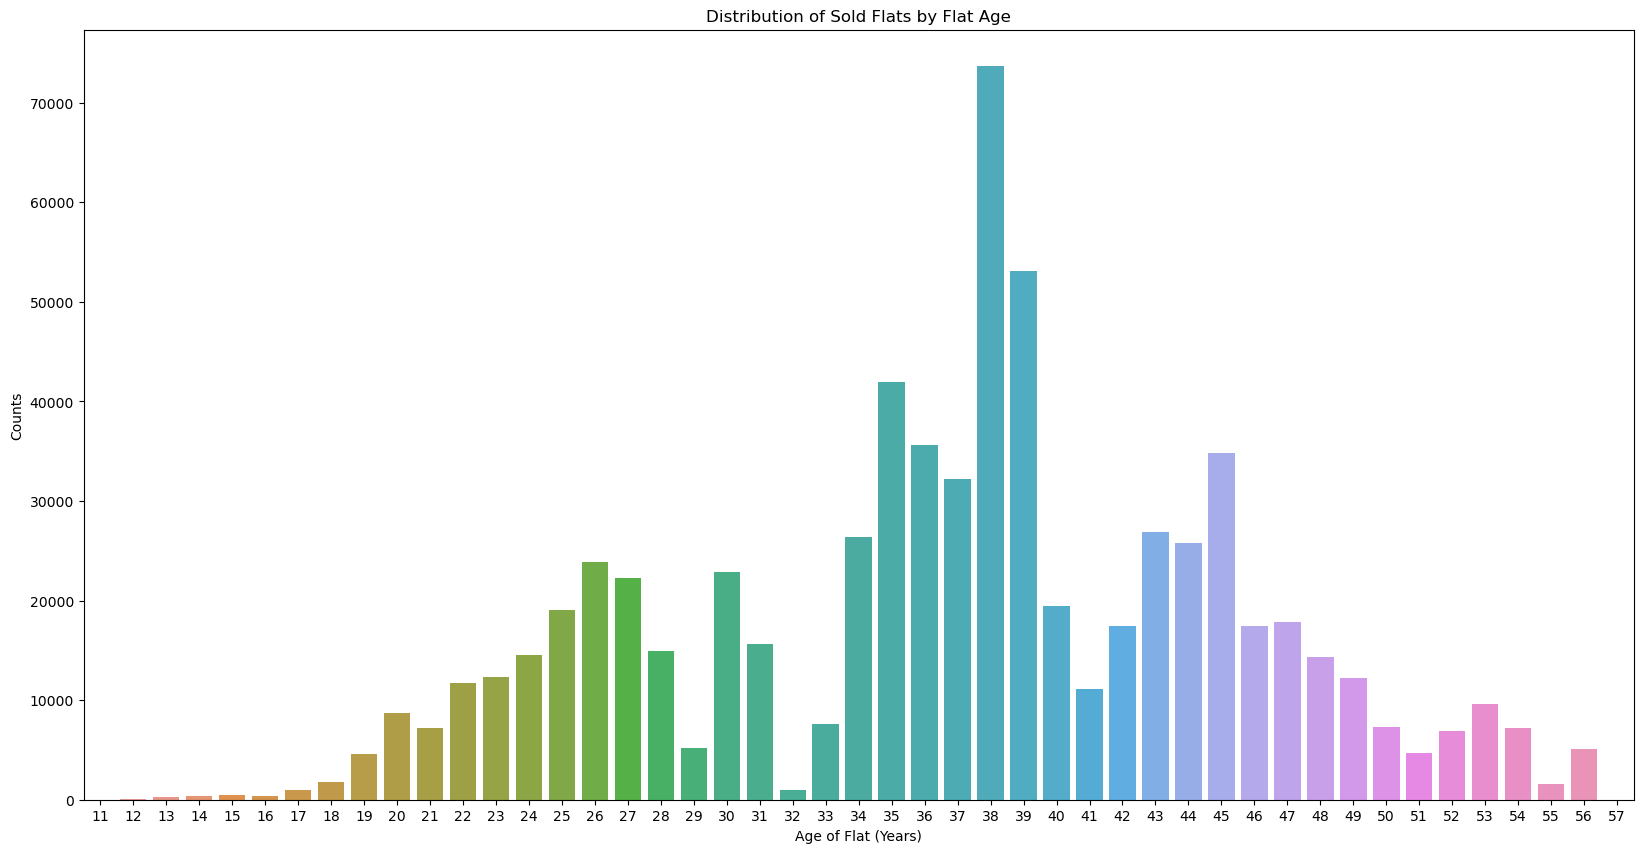

In [187]:
plt.figure(figsize=(20,10))
sns.barplot(x=data2['age_of_flat'].value_counts().sort_index().index, y=data2['age_of_flat'].value_counts().sort_index().values)
plt.title('Distribution of Sold Flats by Flat Age')
plt.ylabel('Counts')
plt.xlabel('Age of Flat (Years)')

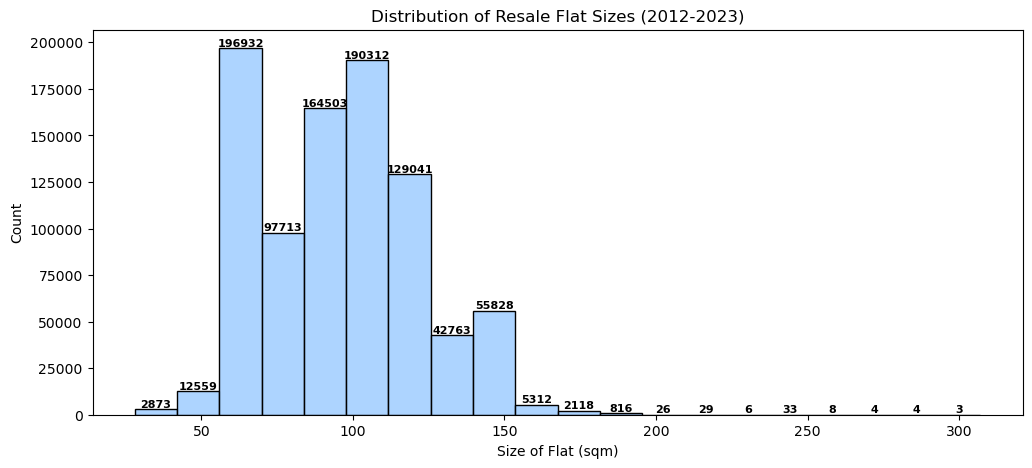

In [188]:
plt.figure(figsize=(12,5))
ax = sns.histplot(data=data, x= 'floor_area_sqm', bins=20, stat='count')
plt.title('Distribution of Resale Flat Sizes (2012-2023)')
plt.xlabel('Size of Flat (sqm)')
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    ax.annotate(f'{int(y)}', (x, y), ha='center', va='bottom', fontsize=8, fontweight='bold')

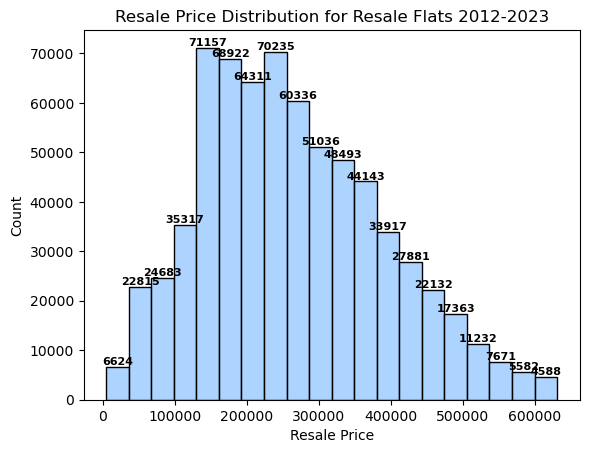

In [189]:
#Plot to look at resale prices distribution 
cx=sns.histplot(data=data2, x= 'resale_price', bins=20, stat='count')
plt.title('Resale Price Distribution for Resale Flats 2012-2023')
plt.xlabel('Resale Price')
for rect in cx.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    cx.annotate(f'{int(y)}', (x, y), ha='center', va='bottom', fontsize=8, fontweight='bold')

Text(0.5, 1.0, 'Top 10 Features and its Correlation to Resale Price')

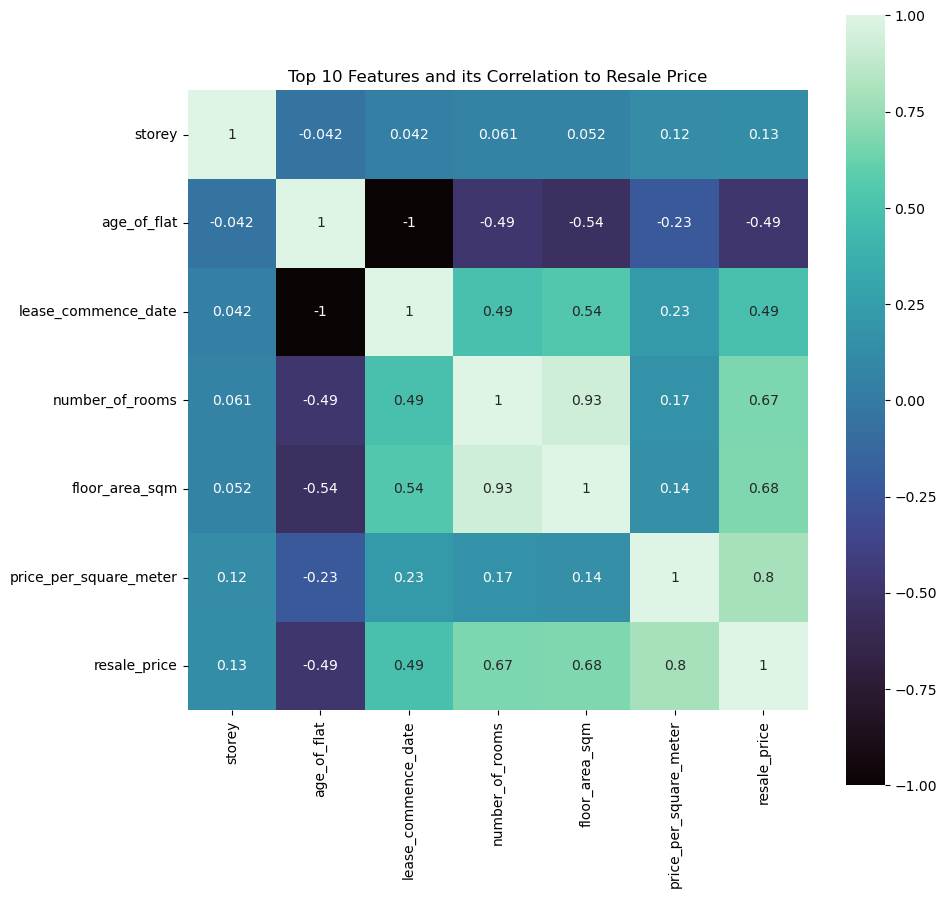

In [190]:
plt.figure(figsize=(10, 10))
sns.heatmap(data2[data2.corr().abs()['resale_price'].sort_values().tail(11).index].corr(), annot=True, cmap='mako', square=True)
plt.title('Top 10 Features and its Correlation to Resale Price')

(0.0, 70000.0)

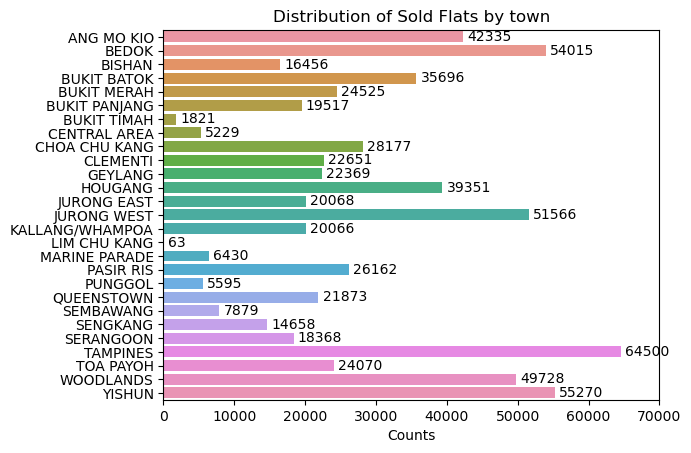

In [198]:
dx=sns.barplot(y=data2['town'].value_counts().index, x=data2['town'].value_counts().values)
plt.title('Distribution of Sold Flats by town')
plt.xlabel('Counts')
dx.bar_label(dx.containers[0], label_type='edge', padding= 3)
dx.set_xlim(0, 70000)

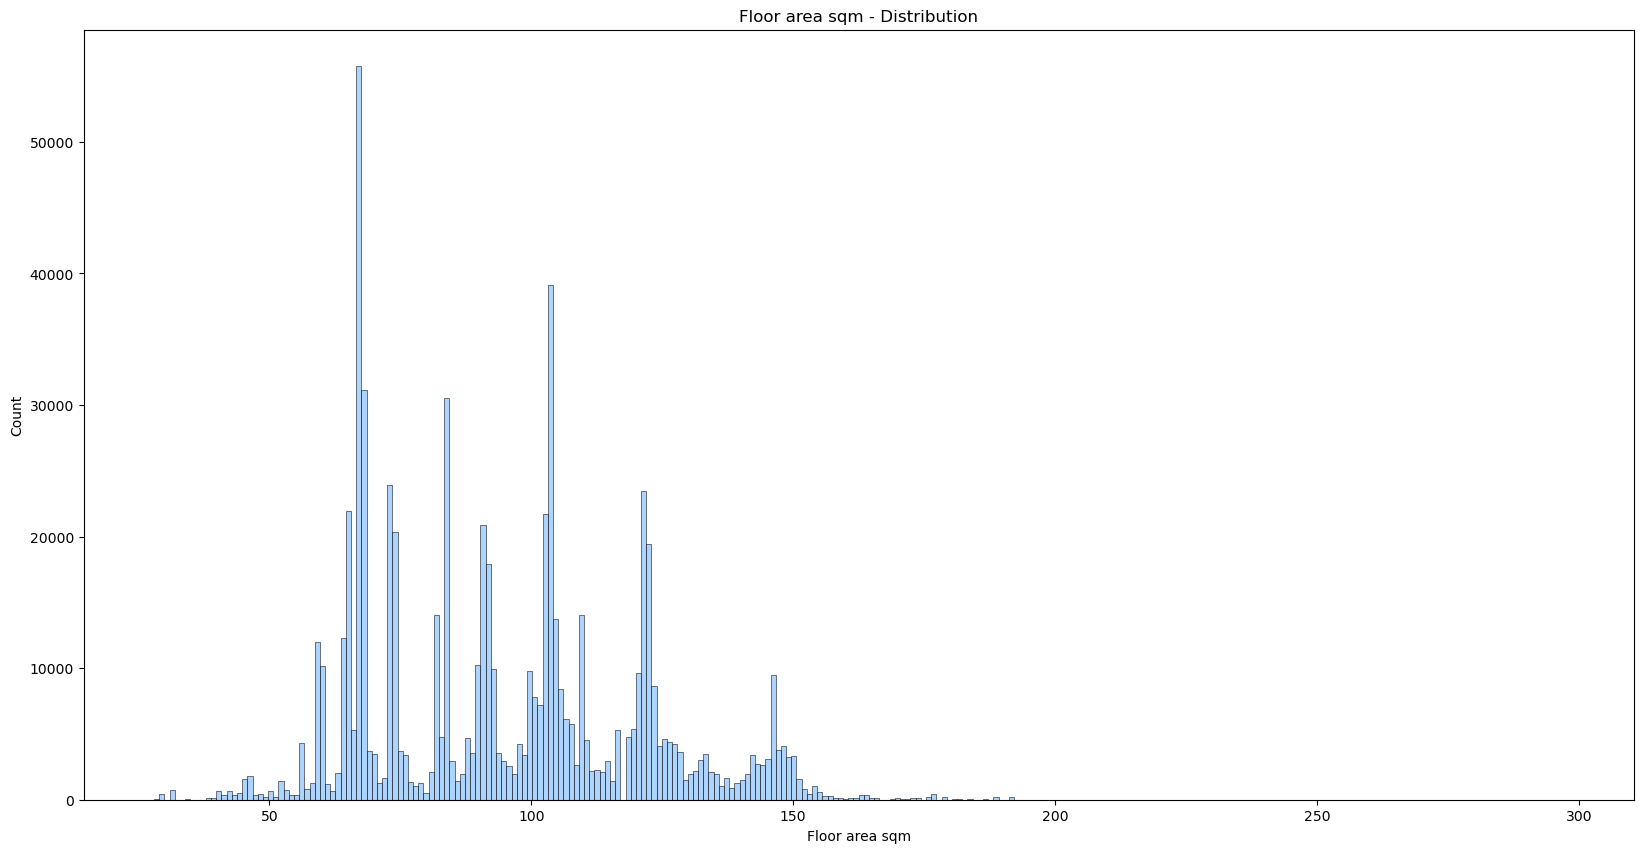

In [207]:
ex=plt.figure(figsize=(20,10))
sns.histplot(data2['floor_area_sqm'].sort_index())
plt.title('Floor area sqm - Distribution')
plt.xlabel('Floor area sqm') 
for rect in ex.patches:
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_height()
    ex.annotate(f'{int(y)}', (x, y), ha='center', va='bottom', fontsize=8, fontweight='bold')
plt.show()

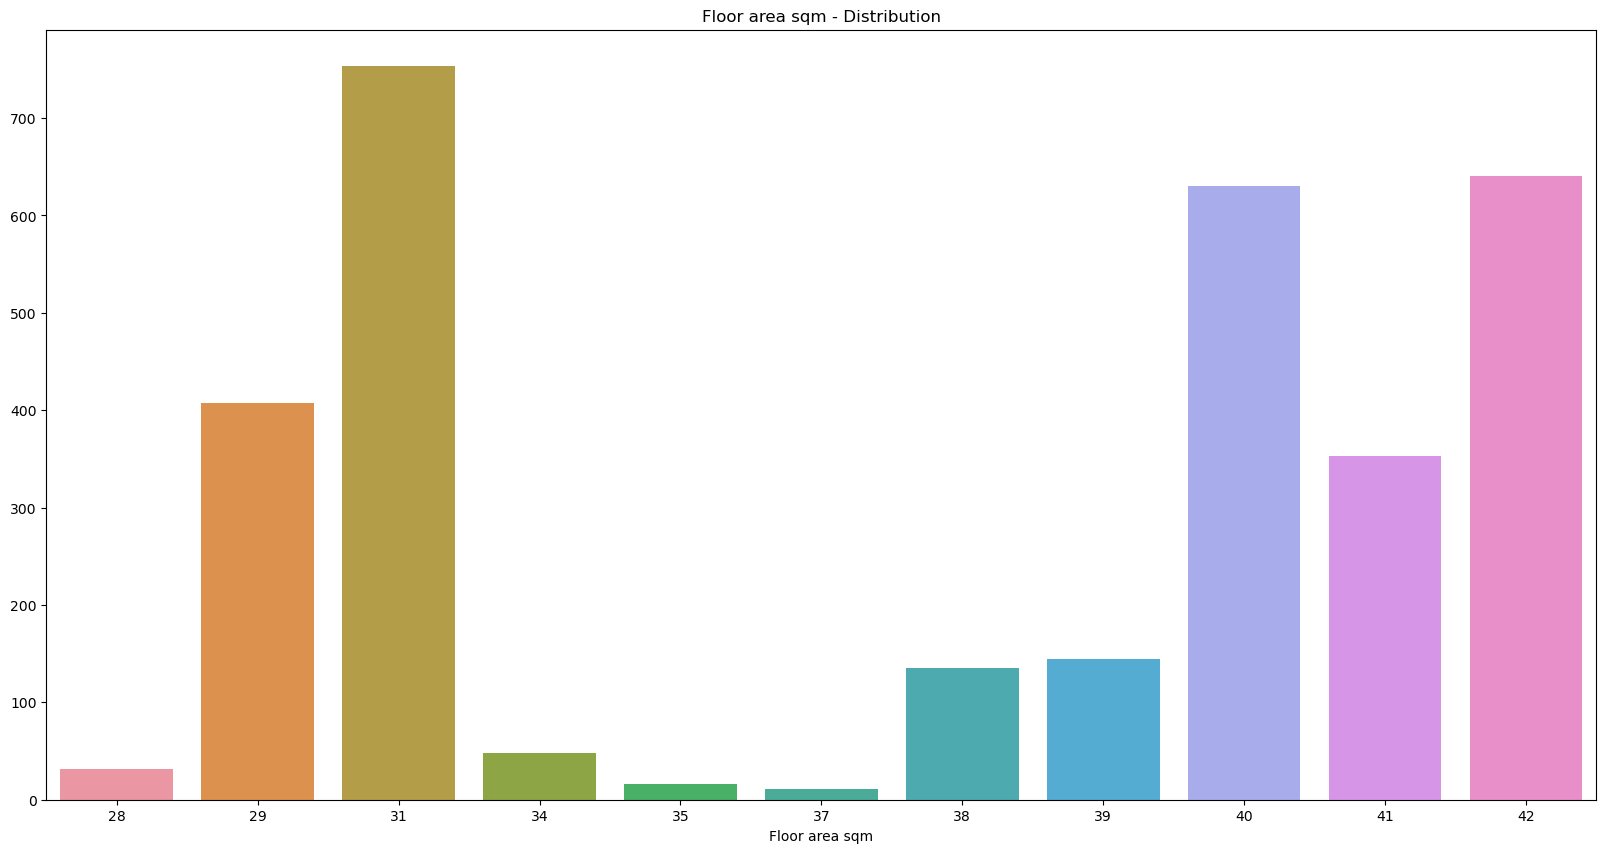

In [205]:
plt.figure(figsize=(20,10))
sns.barplot(x=data2['floor_area_sqm'].value_counts().sort_index().head(11).index, y=data2['floor_area_sqm'].value_counts().sort_index().head(11).values)
plt.title('Floor area sqm - Distribution')
plt.xlabel('Floor area sqm') 
plt.show()

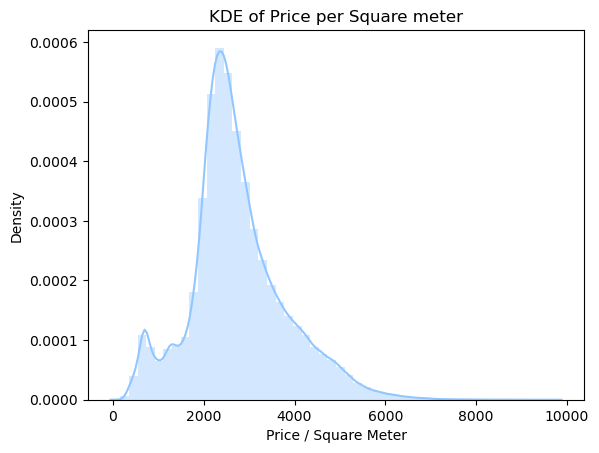

In [208]:
sns.distplot(data2['price_per_square_meter'])
plt.xlabel('Price / Square Meter')
plt.title('KDE of Price per Square meter')
plt.show()

# Bivarient

<Axes: xlabel='resale_price', ylabel='floor_area_sqm'>

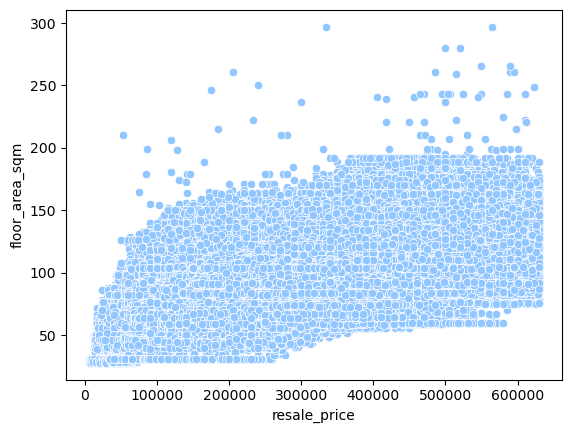

In [209]:
sns.scatterplot(x = 'resale_price',y = 'floor_area_sqm',data = data2)

In [210]:
data2['number_of_rooms'].unique()

array([1, 3, 4, 5, 2, 7, 6], dtype=int64)

C:\Users\vijiv\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


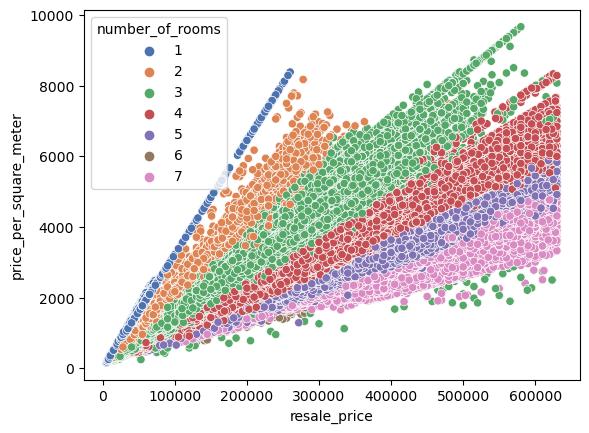

In [46]:
bx=sns.scatterplot(x = 'resale_price',y ='price_per_square_meter' ,hue = 'number_of_rooms',palette="deep",data = data2)
plt.show()

<Axes: xlabel='age_of_flat', ylabel='price_per_square_meter'>

C:\Users\vijiv\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\vijiv\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


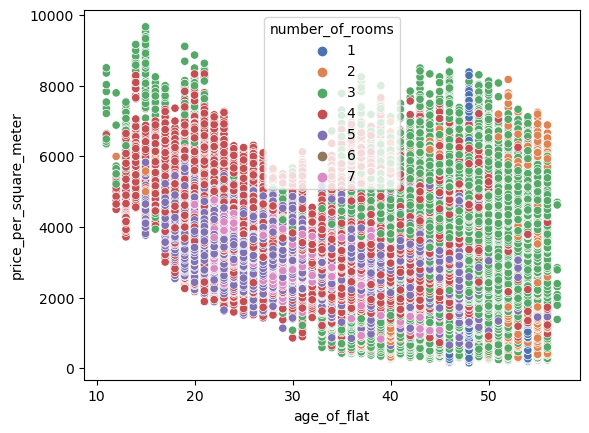

In [47]:
sns.scatterplot(x = 'age_of_flat',y = 'price_per_square_meter',hue = 'number_of_rooms',palette='deep',data = data2)

# multivarient

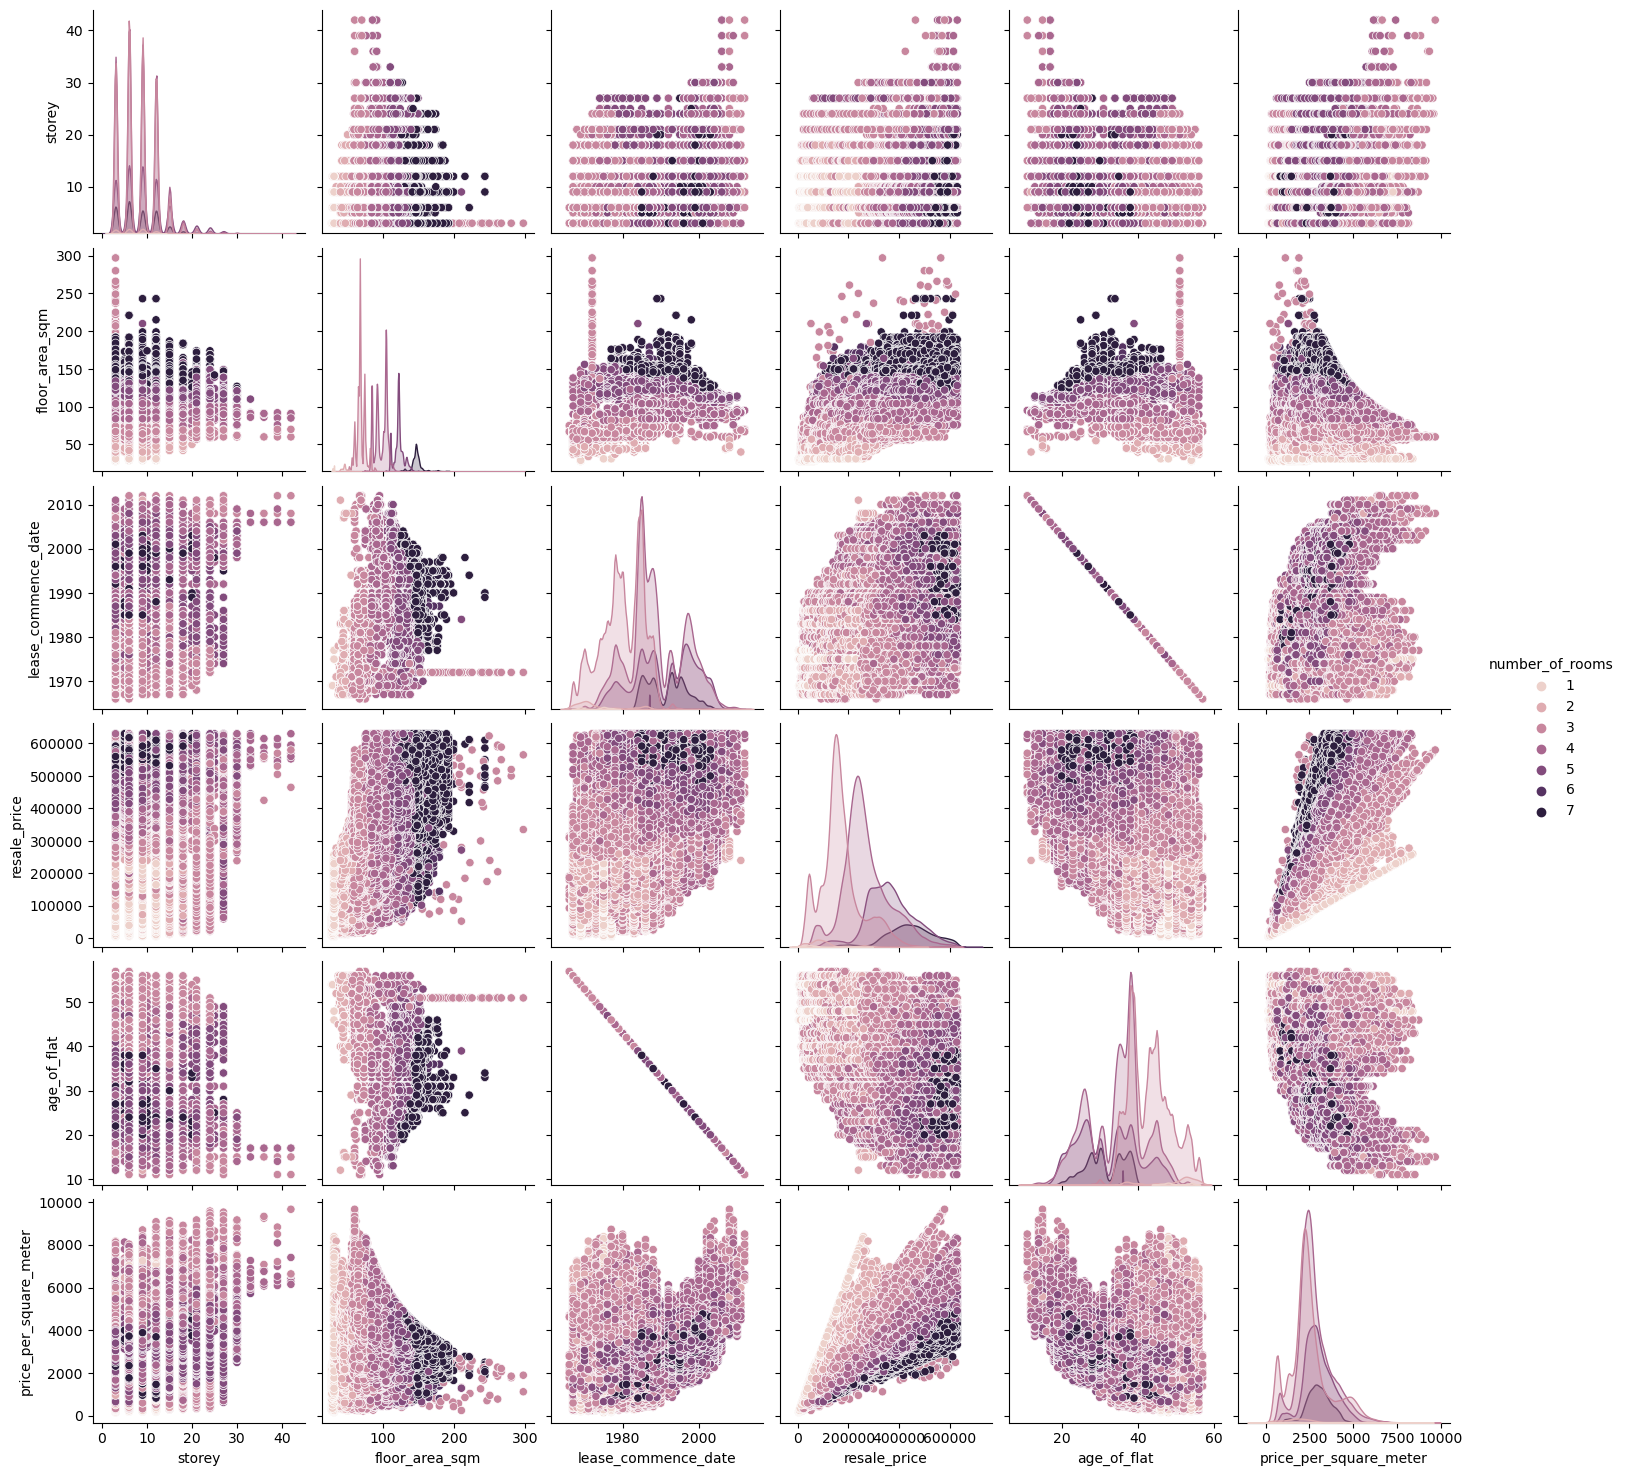

In [48]:
sns.pairplot(data=data2,hue='number_of_rooms')

In [211]:
df_corr = data2[['floor_area_sqm','age_of_flat','price_per_square_meter','resale_price']].corr()
df_corr

,floor_area_sqm,age_of_flat,price_per_square_meter,resale_price
floor_area_sqm,1.000000,-0.542069,0.143863,0.681983
age_of_flat,-0.542069,1.000000,-0.225562,-0.487582
price_per_square_meter,0.143863,-0.225562,1.000000,0.795016
resale_price,0.681983,-0.487582,0.795016,1.000000


<Axes: >

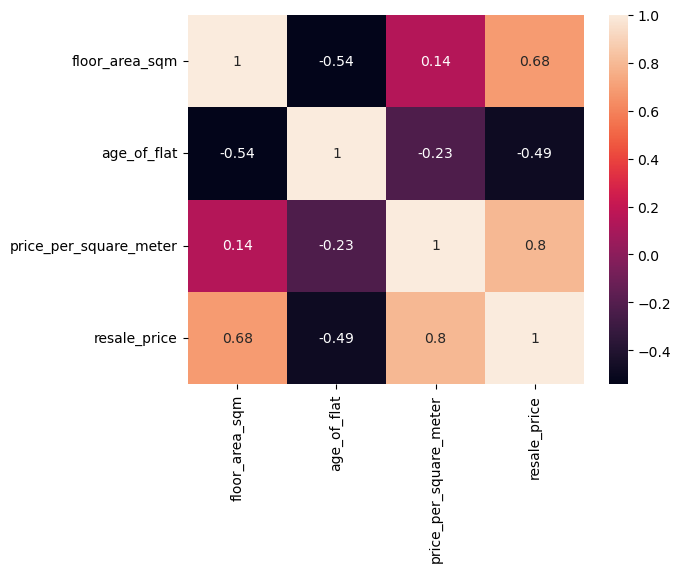

In [212]:
sns.heatmap(df_corr, annot=True)

In [213]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698438 entries, 0 to 913468
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   number_of_rooms         698438 non-null  int64   
 1   storey                  698438 non-null  int32   
 2   floor_area_sqm          698438 non-null  int64   
 3   flat_model              698438 non-null  object  
 4   lease_commence_date     698438 non-null  int64   
 5   resale_price            698438 non-null  float64 
 6   town                    698438 non-null  category
 7   age_of_flat             698438 non-null  int64   
 8   price_per_square_meter  698438 non-null  float64 
dtypes: category(1), float64(2), int32(1), int64(4), object(1)
memory usage: 46.0+ MB


In [214]:
data2['flat_model'].unique()

array(['improved', 'new generation', 'model a', 'standard', 'simplified',
       'model a-maisonette', 'apartment', 'maisonette', 'terrace',
       '2-room', 'improved-maisonette', 'multi generation',
       'premium apartment', 'adjoined flat', 'premium maisonette',
       'model a2', 'dbss'], dtype=object)

In [216]:
data2['flat_model'].value_counts()

model a                188913
improved               184786
new generation         159755
simplified              48625
standard                35644
apartment               25680
premium apartment       22486
maisonette              21668
model a2                 7468
model a-maisonette       1589
adjoined flat             770
terrace                   473
multi generation          390
improved-maisonette        90
premium maisonette         54
2-room                     37
dbss                       10
Name: flat_model, dtype: int64

In [223]:
data2['flat_model']=data2['flat_model'].astype('category')

In [225]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 698438 entries, 0 to 913468
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   number_of_rooms         698438 non-null  int64   
 1   storey                  698438 non-null  int32   
 2   floor_area_sqm          698438 non-null  int64   
 3   flat_model              698438 non-null  category
 4   lease_commence_date     698438 non-null  int64   
 5   resale_price            698438 non-null  float64 
 6   town                    698438 non-null  category
 7   age_of_flat             698438 non-null  int64   
 8   price_per_square_meter  698438 non-null  float64 
dtypes: category(2), float64(2), int32(1), int64(4)
memory usage: 41.3 MB


In [266]:
X = data2.drop(columns= 'resale_price')
y = data2['resale_price']

In [267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123) 

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(523828, 8)
(174610, 8)
(523828,)
(174610,)


# ColumnTransformer

In [280]:
num_columns=['number_of_rooms','lease_commence_date','age_of_flat','price_per_square_meter']

In [282]:
cat_columns=['flat_model','town']

In [283]:
ohe = OneHotEncoder(min_frequency = 10)
ss = StandardScaler()
ct = make_column_transformer(
    (ohe, cat_columns),
    (ss, num_columns))

In [284]:
ct

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(min_frequency=10),
                                 ['flat_model', 'town']),
                                ('standardscaler', StandardScaler(),
                                 ['number_of_rooms', 'lease_commence_date',
                                  'age_of_flat', 'price_per_square_meter'])])

In [286]:
Z_train = ct.fit_transform(X_train)
Z_test = ct.transform(X_test)

In [287]:
Z_train.toarray()

array([[ 0.        ,  0.        ,  0.        , ...,  1.65252823,
        -1.65252823,  1.27461046],
       [ 0.        ,  0.        ,  0.        , ..., -0.8386497 ,
         0.8386497 ,  0.55289906],
       [ 0.        ,  0.        ,  0.        , ..., -0.60139466,
         0.60139466,  0.22312341],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.8386497 ,
         0.8386497 , -1.74310329],
       [ 0.        ,  0.        ,  0.        , ..., -1.07590474,
         1.07590474, -2.16299368],
       [ 0.        ,  0.        ,  0.        , ...,  1.05939063,
        -1.05939063,  0.15824951]])

# Modelling

In [290]:
# Instantiating Linear Regression
lr = LinearRegression()
# Running a fit on train data
lr.fit(Z_train, y_train)

LinearRegression()

In [291]:
# Train score
lr_train_score = lr.score(Z_train, y_train)
print(f'The train score is {lr_train_score}.')

The train score is 0.9523870387310054.


In [292]:
# Test score
lr_test_score = lr.score(Z_test, y_test)
print(f'The test score is {lr_test_score}.')

The test score is 0.9531664314042608.


In [293]:
# Linear Regression Root Mean Squared Error
y_test_preds_lr = lr.predict(Z_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds_lr))
print(f'The root mean squared error is {lr_rmse}.')

The root mean squared error is 27195.23253407244.


r-squared = 0.9532


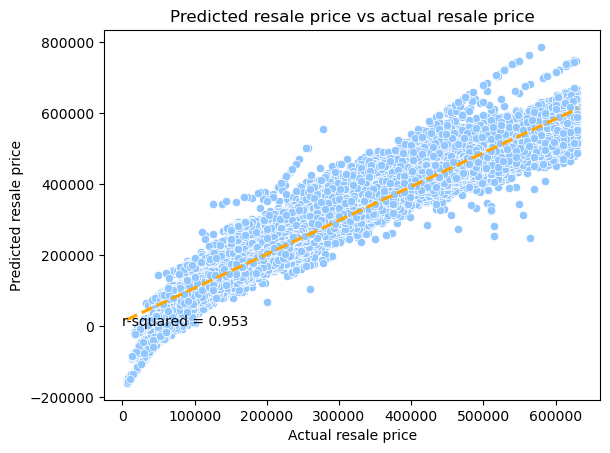

In [294]:
# Create the output DataFrame
output_df = pd.DataFrame({"Actual Price": y_test, "Predicted Price": y_test_preds_lr})

# Plot using Seaborn scatterplot
sns.scatterplot(data=output_df, x="Actual Price", y="Predicted Price")

# Plot the regression line
sns.regplot(data=output_df, x="Actual Price", y="Predicted Price", scatter=False, color="orange", line_kws={'linestyle': 'dashed'})

plt.xlabel('Actual resale price')
plt.ylabel('Predicted resale price')
plt.title('Predicted resale price vs actual resale price')

# Calculate and print the r-squared value
r_squared = r2_score(y_test, y_test_preds_lr)
plt.annotate(f"r-squared = {r_squared:.3f}", (1, 1))
print("r-squared = {:.4f}".format(r2_score(y_test, y_test_preds_lr)))#
plt.show()

# Regression using statsmodels

In [298]:
X = data2[num_columns]

X = sm.add_constant(X)
y = data2['resale_price']
ols = sm.OLS(y, X).fit()

In [299]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           resale_price   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                 3.349e+06
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        22:59:13   Log-Likelihood:            -8.2376e+06
No. Observations:              698438   AIC:                         1.648e+07
Df Residuals:                  698434   BIC:                         1.648e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.6457      0.002   -260.390      0.000      -0.651      -0.641
number_of_rooms         5.835e+04     39.527   1476.314      0.000    5.83e+04    5.84e+04
lease_commence_date      -76.2599      0.164   -466.093      0.000     -76.581     -75.939
age_of_flat            -1230.0469      5.157   -238.516      0.000   -1240.155   -1219.939
price_per_square_meter    82.2011      0.037   2195.334      0.000      82.128      82.275
==============================================================================
Omnibus:                    63772.646   Durbin-Watson:                   0.540
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           463629.750
Skew:                           0.034   Prob(JB):                         0.00
Kurtosis:                       6.991   Cond. No.                     9.46e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.53e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [311]:
# Instantiating Linear Regression
lr = LinearRegression()
# Creating a pipeline that starts off with the column transformer, followed by the LinearRegression
lr_pipe = make_pipeline(ct, lr)

In [313]:
lr_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(min_frequency=10),
                                                  ['flat_model', 'town']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['number_of_rooms',
                                                   'lease_commence_date',
                                                   'age_of_flat',
                                                   'price_per_square_meter'])])),
                ('linearregression', LinearRegression())])

In [312]:
lr_pipe.fit(X_train, y_train)
# Linear Regression Scores
print(f"The train score is: {lr_pipe.score(X_train, y_train)}")
print(f"The test score is: {lr_pipe.score(X_test, y_test)}")

y_test_preds_lr = lr_pipe.predict(X_test)

# Linear Regression Root Mean Squared Error
lr_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds_lr))
print(f'The root mean squared error is {lr_rmse}.')

The train score is: 0.9523870387310054
The test score is: 0.9531664314042608
The root mean squared error is 27195.23253407244.


# Ridge Regression

In [314]:
# Setting alpha range
r_alphas = np.logspace(-2, 1, 100)
# Instantiating Linear Regression
ridge = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
# Creating a pipeline that starts off with the column transformer, followed by the RidgeCV
ridge_pipe = make_pipeline(ct, ridge)

In [315]:
ridge_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(min_frequency=10),
                                                  ['flat_model', 'town']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['number_of_rooms',
                                                   'lease_commence_date',
                                                   'age_of_flat',
                                                   'price_per_square_meter'])])),
                ('ridgecv',
                 RidgeCV(alphas=array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417...
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23284674,
        1.32194115,  1.41747416,  1.51991108,  1.62975083,  1.7475284 ,
        1.87381742,  2.009233  ,  2.15443469,  2.3101297 ,  2.47707636,
        2.65608778,  2.84803587,  3.05385551,  3.27454916,  3.51119173,
        3.76493581,  4.03701726,  4.32876128,  4.64158883,  4.97702356,
        5.33669923,  5.72236766,  6.13590727,  6.57933225,  7.05480231,
        7.56463328,  8.11130831,  8.69749003,  9.32603347, 10.        ]),
                         cv=5, scoring='r2'))])

In [316]:
ridge_pipe.fit(X_train, y_train)
print(f"The train score is: {ridge_pipe.score(X_train, y_train)}")
print(f"The test score is: {ridge_pipe.score(X_test, y_test)}")

# RidgeCV Scores
y_test_preds_ridge = ridge_pipe.predict(X_test)

# RidgeCV Root Mean Squared Error
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds_ridge))
print(f'The root mean squared error is {ridge_rmse}.')

The train score is: 0.9523753889172507
The test score is: 0.9531705401891867
The root mean squared error is 27194.03956697943.


# LassoCV

In [317]:
# Setting alpha range
l_alphas = np.logspace(-20, 5, 25)
#l_alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001]
# Instantiating Linear Regression
lasso = LassoCV(alphas=l_alphas, cv=5, max_iter=10000, tol=1e-1)
# Creating a pipeline that starts off with the column transformer, followed by the LassoCV
lasso_pipe = make_pipeline(ct, lasso)

In [318]:
lasso_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(min_frequency=10),
                                                  ['flat_model', 'town']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['number_of_rooms',
                                                   'lease_commence_date',
                                                   'age_of_flat',
                                                   'price_per_square_meter'])])),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-20, 1.10069417e-19, 1.21152766e-18, 1.33352143e-17,
       1.46779927e-16, 1.61559810e-15, 1.77827941e-14, 1.95734178e-13,
       2.15443469e-12, 2.37137371e-11, 2.61015722e-10, 2.87298483e-09,
       3.16227766e-08, 3.48070059e-07, 3.83118685e-06, 4.21696503e-05,
       4.64158883e-04, 5.10896977e-03, 5.62341325e-02, 6.18965819e-01,
       6.81292069e+00, 7.49894209e+01, 8.25404185e+02, 9.08517576e+03,
       1.00000000e+05]),
                         cv=5, max_iter=10000, tol=0.1))])

In [319]:
lasso_pipe.fit(X_train, y_train)
print(f"The train score is: {lasso_pipe.score(X_train, y_train)}")
print(f"The test score is: {lasso_pipe.score(X_test, y_test)}")

# LassoCV Scores
y_test_preds_lasso = lasso_pipe.predict(X_test)

# LassoCV Root Mean Squared Error
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_test_preds_lasso))
print(f'The root mean squared error is {lasso_rmse}.')

The train score is: 0.951355136789158
The test score is: 0.9521028626960698
The root mean squared error is 27502.294595354662.


In [320]:
lasso.alpha_

1.2115276586285852e-18

# Overall, the baseline linear regression model and ridge regression has the best performance in terms of R2 score and Root Mean Squared Error. 

In [322]:
# Save the model to a file
with open('singapore_sale_project.pkl', 'wb') as file:
    pickle.dump(lr, file)